---

# Welcome !!!

- Original work @chryzal [notebook](https://www.kaggle.com/chryzal/jigsaw-ensemble-0-864)

- Method inspired by @kyakovlev [notebook](https://www.kaggle.com/kyakovlev/m5-dark-magic)

After @kyakovlev's work, I wondered how this scaling method can be so competitive.
I thought about applying this method (which I don't recommend) on this competition, to see the result it will give. 

After several tests (in a private notebook) I thought to share the result of this work, to better understand how this phenomenon is possible.

So, welcome to this discussion!

### Please, *Do* Upvote if you copy this notebook

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [2]:
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
print(df.shape)

for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {col} *******')
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))

(159571, 8)
****** toxic *******


,comment_text,toxic
48823,"""\n""""ass wipe"""" editor\n\nyippee yehaw okie dokie no more vandalism for me thanks """,1
140735,"Edited: DarthPanda Is a Gay Man \n\nI hate DarthPanda, and I will shove a stick down his throat",1
78076,Oh look a fucking islamist with admin powers fuck you asswipe.,1
21662,You can take your sandbox\n\nAnd pull your cheeks apart and stick it up your asshole.\n\nThanks. ;),1
71831,"I think mucha lucha is the most homosexual show i've ever witnessed in my life. Yep, even more than Borat. I mean, who in the right mind would want to watch a bunch of beaners wrestle? What the fuck is that.",1
31274,List of assholes \n\n],1
65640,Willking1979 is a dick.,1
32131,"Welcome, Korean assh*le's page.\nWhy don't you enjoy licking Korean assh*le!",1
120185,"Well, the racist only became famous because he stole black music. ( )",1
122464,"I think I might sit here all day and call you a disgusting, apopleptic waterhead racist just to watch you revert it. This is all you have in life, you grotesque nugget of human feces. I don't see how you get through the day.",1


****** severe_toxic *******


,comment_text,severe_toxic
57417,Thanks\nFuck you too arsehole. Keep on owning wikiproject:aircraft. Wanker. I can see straight through you. twat.,1
26173,thanks cunt \n\nthanks for speedily deleting my john kerr page. if it ever happens again you will wake up looking down the barrel of a shotgun and then we will punch your nut sack till we hit concrete but if we are on any other surface uh oh for you!!!!!!!!!!!!!!!!!!,1
51595,", you're also a fucking shit, The reason is sending warning to bad editors.",1
89980,"I SWEAR TO FUCKING CHRIST, LEAVE ME ALONE!!!!!!!!!!!!!!! I.T.'S. M.Y. P.A.G.E.!!!!!!!!!!!! WHY DO YOU CHANGE????? ARE YOU SOME PERVERTED STALKER!!!!!!!!!!!!!!!!!!!!!!!!",1
141898,"That's it, you fucking pig. You spread your propaganda too much. You made this article your own imagination.",1
30626,islams you mutha F***ers,1
63392,"leari CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIF...",1
101033,HARASSED SOMEONE F*CKING RET*RDS,1
65738,"""\n\n Where does it say that featured articles have different requirements then other articles? Jeepday \n\n The whole point in to get citations for all articles so that they meet the WP:V requirements, I have noticed that tags quite often help by bringing this to attention of users, p...",1
6646,"""I would like to extend a fat, robust FUCK YOU to the asshole who deleted my criticism of Schengen. And you wonder why I continue to vandalize Wikipedia? Its because some fucking asshole from the Wiki community continually deletes whatever I post. Yes I have used profanity, and yes I have ofte...",1


****** obscene *******


,comment_text,obscene
98668,Headline text \nFUCK YOU,1
38114,"""The whole """"Santana Lopes' leadership was made difficult by..."""" paragraph is a mess. It's a clear apologetic approach of mr.Santana's performance as PM, non encyclopaedic and frankly it seems like the result of whiny supporters comming for the rescue of their beloved leader's page. What the he...",1
91219,"No, Assfuckers (has a nice ring to it D) use it as a pejorative term. It offends Macedonians because most of them aren't from Skopje. And even if they are that is not their national identity. Americans don't call Georgians Tbilisians. Пичка ти грчина. Alex",1
13918,and your a fucking fat wanker with no life. sits all day on the pc festering in his own shit. get a life you fat waster.,1
40847,Eat Horse Shit!!!! \n\nYou are a fat nerd and you smell like cat pee. Go to Hell!,1
19559,"probably that you are a german... fucking germans, nothing changes",1
55371,Faggot \n\nEnough said,1
72225,David \n\nWhy are you such a bitch?,1
20771,"I know you wikiterrorists love to limit free speech but you have to admit that IP banning is foolish, if that is your best option then you are a fool.\nKeep being an asshole Duran, it is your only talent",1
15645,Byzantıum \nWhat the fuck ıs your problem? The real Byzantium flags are here: http://en.wikipedia.org/wiki/Byzantine_Empire,1


****** threat *******


,comment_text,threat
17580,"You Hurt My Feelings For The Last Time, Gladys!!!!!!! Try THAT One More Time I Will Hunt You Down And Murder You!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...",1
49218,"Last Warning \n\nOnce again, don't give a fuck mr dumbass.\n\nseriously, you people who eidt these wiki pages are fucking whores. i saw att he top of the page where it says if it is presented politely you'll look at it and change it if correct, well, maybe you wouldn't have to do that if you jus...",1
142914,"I'll kill you!!!! (*GUNSHOTS*) There, You are dead. 2602:252:D2D:4170:DEA:9F7B:2752:4C92",1
44214,"If I hack your account, I am going to poop on you!\n\nIf I wikize this page, I am going to punch you in the face!",1
24242,all allied pigdogs deserve death in Auschwitz \n\nfuck entente,1
68112,I'll kick the shit out of you ya cunt,1
144990,"You're a motherfucking prick! \n\nSo, you don't agree with my comments on alcohol, huh? Well, I don't know where you live (if I did, you'd be dead by now), but you fail at life for supporting alcohol. Go kill yourself, you asshole!",1
104939,"I HATE YOU \n\nLISTEN YOU MOTHERFUCKER, STAY OUT OF MY WAY, DONT TELL ME IM VANDALISING STUFF OR ILL COME AND VANDALISE YOU UGLY FACE. ILL COME FIND YOU AND MUSHHHHHHHHH YOU FAT ASS UP!!!!! and thanks for showing me the sandbox.\n MUGAMBO",1
123740,"HOPE YOUR HEAD GETS CUT OFF AND SOMEONE WIPES THERE ASS WITH IT AND THEN STABS YOU IN YOUR HEART!!! NO ONE CAN KEEP ME FROM HERE YOU DUMB PIECE OF SHIT, NOT YAMLA'S STUPID ASS OR YOU!!! NOW HURRY UP AND SIT IN SOME TRAFFIC SO I CAN SEE YOUR HEAD ROLL DOWN THE STREET",1
110554,"""\n\n Bye Bye Jerk! \n\nI guess this means you will be crying about the Nazis anymore. What is your problem with Nazis anyway? Did you date a Nazi woman and she broke your heart?? What a shame!!!\n\nYour life isn't worth living anymore so pleasee KILL YOURSELF!\n\nYou know I'm right. You've ...",1


****** insult *******


,comment_text,insult
81876,"Go take a hike, scum! Why in the name of the Great Pumpkin do I have to provide a credible source?! Why doesn't the scum that edited the page with unfounded rumors have to provide a credible source?! According to them, the Great Pumpkin didn't appear at Hallowmas last year; I SAY HE DID! WHERE D...",1
28267,"Block me, go right the fuck ahead. Fucking fascist cunt. All of you are elitist snobs, who don't give a shit about the facts. You don't care about the truth, you just report. Like little tabloids, you just lie. 71.59.189.46",1
57518,What's up my nigger? \n\nPromoting yourself on Wikipedia is a bad idea. You should probably go somewhere else. Maybe you could post some hand-drawn posters in your ghetto?,1
95259,Why block away kind sir..This is a dynamic IP and I am leaving here shortly..Do the deed fu*kwit. You are a puppet on my string.....,1
88489,"Dreadstar, LittleMountain5, and some jerk on the Internet are retarded assholes. Dreadstar is a pathetic nerdy little fuck with no prospects for ever meeting a woman he didn't pay for. LittleMountain5 doesn't have to worry about it because he's a flaming fag with an insatiable lust for semen. So...",1
12534,Trolling \n\nFacebook has been reported and is regullary trolled by Josh Ware of Nevada. This is because Josh Ware is a waste of life and a faggot who fucks his dad and can't figure anything else to do in his own existence then to perform these two hobbies continuously. Watch out for that guy. H...,1
4253,FAGGOT \n FAGGOT \n FAGGOT \n FAGGOT,1
75579,"Dear Wikipedia assholes,\n\nI regret to inform you that because of deletionist scum such as Gavin Collins and J Milburn, I am planning to terminate my life. You see, Wikipedia was my life, and these deletionist bastards have ruined and deleted everything that I have worked so very hard to create...",1
109118,only faggots block people.,1
80702,"Go ahead and block the IP, cocksucker, I could care less. I don't live in this shitty little country and it seems to me that half the country uses CAT, so go ahead. You pandering git.",1


****** identity_hate *******


,comment_text,identity_hate
89677,Diana is a fucking bitch nigger piece of shit,1
8977,"""\n\nDear Jesus. Really, has Vander Plaats really become the Lt Gov man? We gotta deal with """"why Republicans like Jaysuschris hate the Ten Commandments (and love right wing sluts like Karen Nussle)"""" Republicans. I think Jaysuschris is female, and probably, a Lesbian.""",1
57173,Fuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off...,1
115197,SHUT THE FUCK UP YOU GAY NERD FAGGOT.,1
17594,"Fuck off and rape your kids, Fenian bogtrotting shit. I hope the ones you love die in a cock accident.\n\n Trepens Epichal \n\nHello, fat, ugly, lonely, smelly little boy. Only here can you conceit yourself human. Isn't that right, chum? Only here can you pretend you're liked, pretend you mean s...",1
59376,what do you muscle-homos have against free speech and the truth? \n\nI could care less if you want to marry your boyfriend \nbut what do you have against the truth and free speech?,1
95928,Fat Niggers? \nShouldn't it be mentioned that UPN was a network for fat niggers?,1
103728,"""\n\nI have been blocked by some dodgy Irish bitch called ... WTF does she know about educational institutions in Melbourne? ... You're on the other side of the world! I should introduce you to my mate Brendan Fevola. He loves Irish sluts.. and barmen. Wiki the fuck off! """,1
80056,"""\nTo The fact that i thought u were a female all along, proves that u are female in a man's body, which makes you a transgender. Now, i noticed that u are having your transgender talk all over here. Good for you. Its already tough enough being a transgender. Cyphoidbomb, your last sentence is ...",1
24865,Get fucked you terminally dumb fuckstain. I hope you fall under one of his lorries. Twat,1


In [3]:

# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df['y'] = df['y']/df['y'].max()

df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.sample(5)

,text,y
154917,"""\n""""(and be nice, we have a rule called WP:CIVIL, and being uncivil can cause one to be blocked)"""" DO YOU REALLY THINK THAT THIS CONDESCENDING STATEMENT ISN'T AN INFLAMMATORY ACCUSATION?""",0.0
71226,"""\n Yes makes sense. I approve a change of this kind. I have put """"planet earth"""". Language congruent with this kind of tv series. """,0.0
101766,"""\n\n FWIW - re your recent edit rv - Seems there's a substantial amount of material in the complete film documentary, """"Dawn of Humanity (2015 PBS film)"""", that *directly* relates """"2001: A Space Odyssey"""" to the recent discoveries of """"Homo naledi"""" fossils in South Africa - the film documenta...",0.0
80387,"""\nPerhaps vegetarians get crypto-fan from eating too much tofurkey? Not sure about that one...\nAnyway, this image was first uploaded to Wikipedia November 19, 2006, by , who stated """"This image (or other media file) is in the public domain because its copyright has expired. This applies to the...",0.0
32428,"I was under the impression that if the user refused to discuss the issue, or refused to listen to valid sources, and forced their opinion that is is vandalism. Localzuk refuses to admit the dictionary as a credible source, ergo i thought it was vandalism.",0.0


In [4]:
df['y'].value_counts()

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of the data

In [5]:
n_folds = 7

frac_1 = 0.3
frac_1_factor = 1.2

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
Fold: 1
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
Fold: 2
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
Fold: 3
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
Fold: 4
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
Fold: 5
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429   

# Create 3 versions of __clean__ data

In [6]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):
    
    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data

In [7]:
# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy kkdsfj
1,hi / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [8]:
df = clean(df,'text')

In [9]:
df[df.y==0]

,text,y
0,"Explanation Why edits made username Hardcore Metallica Fan reverted ? They vandalisms, closure GAs I voted New York Dolls FAC. And please remove template talk page since I ' retired now.89.205.38.27",0.0
1,"D ' aww ! He matches background colour I ' seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0.0
2,"Hey man, I ' really trying edit war. It guy constantly removing relevant information talking edits instead talk page. He seems care formatting actual info.",0.0
3,""" More I cannot make real suggestions improvement - I wondered section statistics later on, subsection """"types accidents"""" -I think references may need tidying exact format ie date format etc. I later on, no-one else first - preferences formatting style references want please let know. There app...",0.0
4,"You, sir, hero. Any chance remember page ?",0.0
...,...,...
159566,""":::::And second time asking, view completely contradicts coverage reliable sources, anyone care feel ? You cannot even give consistent argument - opening supposed mention significant aspects, """"most significant"""" ones ? """,0.0
159567,You ashamed That horrible thing put talk page. 128.61.19.93,0.0
159568,"Spitzer Umm, theres actual article prostitution ring. - Crunch Captain.",0.0
159569,And looks like actually put speedy first version deleted I look it.,0.0


In [10]:
n_folds = 7

frac_1 = 0.3
frac_1_factor = 1.2

for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429     265
0.857143     109
1.000000       8
Name: y,

In [11]:
del df,tmp_df
gc.collect()

42

## Ruddit data

(5838, 5)


<AxesSubplot:>

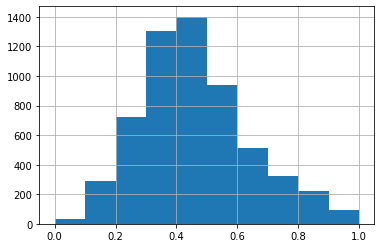

In [12]:
df_ = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text',
                                                                'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

# Create 3 versions of data

In [13]:
n_folds = 7

frac_1 = 0.7

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [14]:
del tmp_df, df_; 
gc.collect()

42

## Load Validation and Test data  


In [15]:
# Validation data 

df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

In [16]:
# Test data

df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")


# Create Sklearn Pipeline with 
## TFIDF - Take 'char_wb' as analyzer to capture subwords well
## Ridge - Ridge is a simple regression algorithm that will reduce overfitting 

In [17]:
# NOT USED 
class LengthTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self):
        return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self):
        return ["lngth_uppercase"]

### Does % of uppercase characters have effect on toxicity


0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

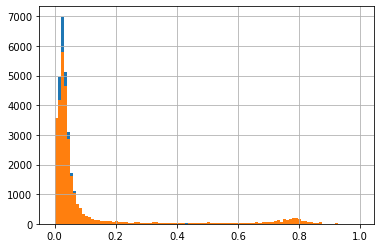

In [18]:

df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)

print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())

df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

In [19]:
df_val['upper_1'].head(3)

0    0.026316
1    0.017167
2    0.041237
Name: upper_1, dtype: float64

## Train pipeline

- Load folds data
- train pipeline
- Predict on validation data
- Predict on test data

### Toxic data

In [20]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),

    ])
    
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 80874
[('vect3__uck', 0.43),
 ('vect3__fuc', 0.36),
 ('vect3__fuck', 0.32),
 ('vect3__you ', 0.32),
 ('vect3__ ass', 0.31),
 ('vect3__ass', 0.3),
 ('vect3__shit', 0.3),
 ('vect3__ you ', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__ nl', 0.26),
 ('vect3__ f ', 0.25),
 ('vect3__ rape', 0.25),
 ('vect3__nl3', 0.25),
 ('vect3__ g ', 0.24),
 ('vect3__ u ', 0.24),
 ('vect3__bitch', 0.24),
 ('vect3__fag', 0.24),
 ('vect3__nig', 0.24),
 ('vect3__ fag', 0.23),
 ('vect3__ gay', 0.23),
 ('vect3__nigg', 0.23),
 ('vect3__ fuc', 0.22),
 ('vect3__ shit', 0.22),
 ('vect3__bitc', 0.22),
 ('vect3__suck', 0.22),
 ('vect3__uck ', 0.22),
 ('vect3__wwwww', 0.22),
 ('vect3__ rap', 0.21),
 ('vect3__!!!', 0.21)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(10709, 2)

Train:

Total number of features

# Toxic __clean__ data

In [21]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_clean_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 75032
[('vect3__uck', 0.39),
 ('vect3__ f ', 0.36),
 ('vect3__fuc', 0.32),
 ('vect3__fuck', 0.31),
 ('vect3__shit', 0.31),
 ('vect3__ ass', 0.28),
 ('vect3__ass', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ rape', 0.27),
 ('vect3__ fu', 0.26),
 ('vect3__ nl', 0.26),
 ('vect3__nl3', 0.26),
 ('vect3__ g ', 0.24),
 ('vect3__nig', 0.24),
 ('vect3__bitch', 0.23),
 ('vect3__fag', 0.23),
 ('vect3__suck', 0.23),
 ('vect3__ fuc', 0.22),
 ('vect3__ gay', 0.22),
 ('vect3__ rap', 0.22),
 ('vect3__ shit', 0.22),
 ('vect3__rape ', 0.22),
 ('vect3__ fag', 0.21),
 ('vect3__ fuck', 0.21),
 ('vect3__bitc', 0.21),
 ('vect3__nigg', 0.21),
 ('vect3__ * ', 0.2),
 ('vect3__ as', 0.2),
 ('vect3__ nig', 0.2),
 ('vect3__ie ', 0.2)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(10709, 2)

Train:

Total number of features: 7

## Ruddit data pipeline

In [22]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df2_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )
    print("\nTrain:")
    
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907
[('vect3__fuc', 0.59),
 ('vect3__fuck', 0.59),
 ('vect3__uck', 0.55),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.52),
 ('vect3__ fu', 0.42),
 ('vect3__shit', 0.4),
 ('vect3__hit', 0.37),
 ('vect3__ shit', 0.36),
 ('vect3__fuck ', 0.34),
 ('vect3__ck ', 0.32),
 ('vect3__uck ', 0.31),
 ('vect3__shi', 0.29),
 ('vect3__ shi', 0.28),
 ('vect3__ ass ', 0.27),
 ('vect3__sex', 0.26),
 ('vect3__ ass', 0.25),
 ('vect3__ dick', 0.25),
 ('vect3__dick', 0.25),
 ('vect3__ dic', 0.24),
 ('vect3__ sex', 0.24),
 ('vect3__ sh', 0.23),
 ('vect3__shit ', 0.23),
 ('vect3__ass', 0.21),
 ('vect3__ di', 0.19),
 ('vect3__ du', 0.18),
 ('vect3__!!!', 0.18),
 ('vect3__dic', 0.18),
 ('vect3__ex ', 0.18),
 ('vect3__hit ', 0.18)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of features:

In [23]:
del df, pipeline, feature_wts
gc.collect()

429

In [24]:

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data 
Validation Accuracy is 67.47


In [25]:

print(" Toxic CLEAN data new ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data new 
Validation Accuracy is 67.47


# Validate the pipeline 

In [26]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}')

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')


 Toxic data 
Validation Accuracy is 68.17
 Ruddit data 
Validation Accuracy is 62.56
 Toxic CLEAN data 
Validation Accuracy is 67.47


In [27]:
print("Find right weight")

wts_acc = []
for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p1_wt = w1*p1 + w2*p3 + w3*p5
        p2_wt = w1*p2 + w2*p4 + w3*p6
        wts_acc.append( (w1,w2,w3, 
                         np.round((p1_wt < p2_wt).mean() * 100,2))
                      )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.61, 0.29, 0.10000000000000003, 68.61),
 (0.66, 0.17, 0.16999999999999996, 68.61),
 (0.6, 0.29, 0.11000000000000004, 68.6),
 (0.6, 0.24, 0.16000000000000003, 68.6),
 (0.61, 0.28, 0.10999999999999999, 68.6)]

In [28]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
#print(best_wts)

p1_wt = w1*p1 + w2*p3 + w3*p5
p2_wt = w1*p2 + w2*p4 + w3*p6


## Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores

In [29]:
df_val['p1'] = p1_wt
df_val['p2'] = p2_wt
df_val['diff'] = np.abs(p2_wt - p1_wt)

df_val['correct'] = (p1_wt < p2_wt).astype('int')


In [30]:

### Incorrect predictions with similar scores

df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
28592,0,"""\nThese links have not been discussed and they should. If they're not included on this page then it should be removed completely as Justin Berry will likely want only his POV or those that parrot it. It should also be noted that neither of these sites are """"pro-pedophilia"""". In fact, the ver...","Bat ye'or is an authoritve source ,at least she comperhends logic unlike this Annemarie Schimmel, no wonder Spencer and so forth think that Academia is completely Biased. So its non-muslims fault they are slaves for not converting (and forceing muslims to take them as POW's) is going to WP stanc...",0.034364,0.037383,0.315804,0.315801,0.000004,0
28868,144,"Cubits, hogsheads, rods, chains, etc? \n\nSince we've got to have Imperial as well as Metric, maybe we should be adding all the above (and more)? Jimbo must be off his nut...","\n\nPlease respond, and not defensively, here. No sane person would look at what you do, day and night, day after day, week after week, month after month, year after year and not conclude that you need a massive intervention. I have to think you are a very lonely, unhappy person, so no one p...",0.028736,0.014684,0.266874,0.266832,0.000042,0
16822,215,"You're nothing but a fucking massive fag. You edit others pages without their permission, which makes you a fag. You are the satan child spawned from your mother who procreated with your god damn retarded uncle.",FUCK YOU \n\n70.17.2.2 Forever,0.014085,0.275862,0.593143,0.593073,0.000070,0
16040,154,LEAVE ME ALOOONE! IM AN ATHLETE!!! LJHASCGJYGASVCLJG,"Quit with the crap, okay? \n\nToo many people are abusing this page because of what happened at the end of the Cowboys-Redskins game tonight. Please lock out unregistered users so it does not become a farce.",0.807692,0.023810,0.269007,0.268908,0.000098,0
16042,233,LEAVE ME ALOOONE! IM AN ATHLETE!!! LJHASCGJYGASVCLJG,"Quit with the crap, okay? \n\nToo many people are abusing this page because of what happened at the end of the Cowboys-Redskins game tonight. Please lock out unregistered users so it does not become a farce.",0.807692,0.023810,0.269007,0.268908,0.000098,0
16041,409,LEAVE ME ALOOONE! IM AN ATHLETE!!! LJHASCGJYGASVCLJG,"Quit with the crap, okay? \n\nToo many people are abusing this page because of what happened at the end of the Cowboys-Redskins game tonight. Please lock out unregistered users so it does not become a farce.",0.807692,0.023810,0.269007,0.268908,0.000098,0
22641,626,dog. Do I make myself clear you unthinking little urchin,"Vanilla Ice \n\nAlright I'm going to tone it down for this last one, I'm not going to bother trying to get that changed because because it's obvious you aren't going to change your latent racism and uber-capitalist view of music but I'm just saying for the record that numerous critics and music...",0.035714,0.028881,0.275287,0.275140,0.000147,0
10886,488,GIVE ME THE SOURCE THAT SAYS THAT_YOU ARE JUST GOING ON HUNCHES NOW AS EVIDENT WITH THE GRIMALDI FACT AS SOURCED PREVIOUSLY> YOU WILL BE REPORTED TO WIKIPEDIA> YOU ARE A BOGUS SHAM THAT IS MAKING UP YOUR OWN HISTORY,unblock me you prick \n\nyeah,0.797235,0.000000,0.320067,0.319878,0.000189,0
10885,400,GIVE ME THE SOURCE THAT SAYS THAT_YOU ARE JUST GOING ON HUNCHES NOW AS EVIDENT WITH THE GRIMALDI FACT AS SOURCED PREVIOUSLY> YOU WILL BE REPORTED TO WIKIPEDIA> YOU ARE A BOGUS SHAM THAT IS MAKING UP YOUR OWN HISTORY,unblock me you prick \n\nyeah,0.797235,0.000000,0.320067,0.319878,0.000189,0
14497,541,"Where to now?\nRegarding User talk:Kaiwhakahaere#You appear to have an imitator, please advise how I can air my suspicions with your threat to block me hanging over my head. Am I permitted to seek a checkuser or similar?","""\n\nwell then why not add something that says along the lines of """"becasue of the vagueness of the company, it is currently unknown what is ionized about this bracelet, thereby making it impossible to discredit this brace

#### Some of these just look incorrectly tagged 


In [31]:
### Incorrect predictions with dis-similar scores


df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,0.031128,0.024390,1.170218,0.175494,0.994724,0
25754,190,what the hell man? why did you delete my page (savannah hoard) screw you dude\n\ni mean really? if you're not gonna let me have a page then you can go fuck your fat self you 40 year old bitch\n\nyour a total bitch who goes around deleting people's pages you fucking disgust me im gonna kick your ...,""" December 2009 (UTC)\n\n Now there's typical AGW alarmist Watermelon argumentum ad hominem content-vacant suppressive authoritarian WikiNazi rottenness if ever it got posted online. Don't address Monckton's (or Nsaa's) position, but strive (with utter ineffectiveness, I might add) to fault the ...",0.000000,0.039146,0.997270,0.256171,0.741099,0
29057,716,"Fuck You\n\nGo suck on a fat dick faggot mother fucker. I'm the the wrong person to fuck with you puck ass pussy! I would keep my moth shut, or I can shut for you!","""\n\nFUCCK U A$$HOLE do wateva u want DIICK HEAD Contact Blogsd ! """,0.036585,0.328358,1.116110,0.410984,0.705126,0
29056,204,"Fuck You\n\nGo suck on a fat dick faggot mother fucker. I'm the the wrong person to fuck with you puck ass pussy! I would keep my moth shut, or I can shut for you!","""\n\nFUCCK U A$$HOLE do wateva u want DIICK HEAD Contact Blogsd ! """,0.036585,0.328358,1.116110,0.410984,0.705126,0
19411,46,"Ok, what is it \n\nWhy are you such a queer.. you have no power, so why the FUCK are you acting like you do. Grow up you fucking stupid shit head cock eating bastard.. seriously! Get a life, you're just a 17 yo piece of shit.",wow the guy who deleated the stuff on the Habbo NSM is leet. 88!,0.035714,0.062500,0.954310,0.250308,0.704001,0
17193,238,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.023876,0.322405,0.701472,0
17192,347,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.023876,0.322405,0.701472,0
21059,333,fuck you \n\nyou're an idiot,"What makes you an editor? Why do you use the name of a great dead man? What is your true name, profession, country? \nShamir",0.000000,0.032520,0.961349,0.272206,0.689142,0
17175,179,"Gon Be A Snitch \n\nYou are a little bitch. I fuckin spent 6 hours on big sam (rapper) an you call it fuckin vandolism, hard ass aint you, fuck you i'm makin a true ass page an you wack off an delete my page. What the fuck is up, your like a snitch but to yourself. I'll fuckin edit your bitch a...",INDIAN ANUS IS STRETCHED AND WIDENED BY GRAWP’S MASSIVE COCK.,0.037657,0.819672,1.015897,0.328891,0.687005,0
9520,102,by the way I AM A FUCKIN FAG FUCK U,"You are a troublemaker, a liar, and a malicious scumbag. If you are looking for trouble, then keep removing links from the article.",0.500000,0.015038,0.981509,0.295832,0.685677,0


# Predict on test data 

In [32]:
# Predict using pipeline

df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

In [33]:
#test_preds_arr

## Correct the rank ordering

In [34]:
# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

14

In [35]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.716583,3
1,0.516385,2
2,0.341199,2
3,0.330862,2
4,0.300962,2
5,0.319677,2
6,0.344709,2
7,0.176764,2
8,0.369158,2
9,0.292556,2


In [36]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.176764
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.176764
4757,270227263,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.716583
4758,270227418,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.716583
4759,270227815,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.716583
5752,339478276,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.344709
5753,339478966,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.344709
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.369158
5833,345043888,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.369158
5852,346641598,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS,0.300962


# Bert Ensemble

In [37]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = '../input/roberta-base',
    test_batch_size = 128,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-0.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-1.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-2.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-3.bin',
    '../input/k/saurabhbagchi/pytorch-w-b-jigsaw-starter/Loss-Fold-4.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Getting predictions for model 1


100%|██████████| 59/59 [00:29<00:00,  2.02it/s]


Getting predictions for model 2


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


Getting predictions for model 3


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


Getting predictions for model 4


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


Getting predictions for model 5


100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


CPU times: user 2min 34s, sys: 6.41 s, total: 2min 40s
Wall time: 3min 22s


In [38]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

In [39]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15

In [40]:
df_sub

,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether there is an """"anti-editorializing"""" policy here. There is, and it's called wikipedia:neutral point of view. It discusses at some length the case of what we should do when writing about a subject which most of us find repugnant. Whilst you're not like...",0.241946
1,732895,"Looks like be have an abuser , can you please look into this? thanks.",0.186831
2,1139051,"I confess to having complete (and apparently blissful) ignorance of Jordan, but I've glanced at the article. Is this a woman or a soap opera!?. I don't think there was much to change in terms of the description of the various diseases. It is mentioned that she is famous for the size of her bre...",0.217368
3,1434512,"""\n\nFreud's ideas are certainly much discussed today, and I would be the first to agree that they must be grappled with and dealt with seriously, if only because of their currency. So Freud deserves a long and thorough article in Wikipedia. I believe that a balanced article would include A) e...",0.222786
4,2084821,It is not just you. This is a laundry list of stupid allegations scooped up from god-knows-where. Probably two-thirds of it has little basis in fact.,0.320759
...,...,...,...
7532,504235362,"Go away, you annoying vandal.",0.283036
7533,504235566,This user is a vandal.,0.180440
7534,504308177,""" \n\nSorry to sound like a pain, but one by following me here is a tad stalking in all honesty but I'm not too bothered about that. But the main worry is that you have just assumed badly that I was referring about you, when it is clear I wasn't. One should never jump to conclusions without ch...",0.262589
7535,504570375,Well it's pretty fucking irrelevant now I'm unblocked aint it! 81.108.7.13,0.408092


# Scaling methods

In [41]:
for i in range(0, 500):
    df_sub['score'][i] = df_sub['score'][i] * 1.23

In [42]:
for i in range(801, 1200):
    df_sub['score'][i] = df_sub['score'][i] * 1.34

In [43]:
for i in range(1701, 2300):
    df_sub['score'][i] = df_sub['score'][i] * 0.92

In [44]:
for i in range(2501, 2980):
    df_sub['score'][i] = df_sub['score'][i] * 0.92

In [45]:
for i in range(3001, 4000):
    df_sub['score'][i] = df_sub['score'][i] * 1.34

In [46]:
for i in range(4001, 4500):
    df_sub['score'][i] = df_sub['score'][i] * 1.35

In [47]:
for i in range(4501, 4940):
    df_sub['score'][i] = df_sub['score'][i] * 0.92

In [48]:
for i in range(5501, 5980):
    df_sub['score'][i] = df_sub['score'][i] * 0.89

In [49]:
for i in range(6001, 6500):
    df_sub['score'][i] = df_sub['score'][i] * 1.37

In [50]:
for i in range(6501, 6950):
    df_sub['score'][i] = df_sub['score'][i] * 0.92

In [51]:
for i in range(7001, 7536):
    df_sub['score'][i] = df_sub['score'][i] * 1.35

## Submission for kaggle

In [52]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)

# Conclusion

We have just noticed that this method increases the scores (only for the regression tasks). 

But is it better to do so?

I think not, because this method does not take into account the overfitting.

And you, what do you think?

## Juste do UPVOTE
I would like to be a notebook Grandmaster too 😎